<a href="https://colab.research.google.com/github/annashiheart/HourlyEnergyConsumption/blob/main/HourlyEnergyConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Data

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annashiheart","key":"34fc94604356b26b959f35d9569a3c5e"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# change permission 
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d robikscube/hourly-energy-consumption

 44% 5.00M/11.4M [00:00<00:00, 25.7MB/s]
100% 11.4M/11.4M [00:00<00:00, 45.4MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "hourly-energy-consumption.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


### Exploring Data

In [ ]:
import pandas as pd
df = pd.read_csv('AEP_hourly.csv')
df.size

242546

In [ ]:
print(df)

                   Datetime   AEP_MW
0       2004-12-31 01:00:00  13478.0
1       2004-12-31 02:00:00  12865.0
2       2004-12-31 03:00:00  12577.0
3       2004-12-31 04:00:00  12517.0
4       2004-12-31 05:00:00  12670.0
...                     ...      ...
121268  2018-01-01 20:00:00  21089.0
121269  2018-01-01 21:00:00  20999.0
121270  2018-01-01 22:00:00  20820.0
121271  2018-01-01 23:00:00  20415.0
121272  2018-01-02 00:00:00  19993.0

[121273 rows x 2 columns]


In [ ]:
df.head(10)

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0
5,2004-12-31 06:00:00,13038.0
6,2004-12-31 07:00:00,13692.0
7,2004-12-31 08:00:00,14297.0
8,2004-12-31 09:00:00,14719.0
9,2004-12-31 10:00:00,14941.0


In [ ]:
df.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


In [ ]:
df = pd.read_csv('AEP_hourly.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
print(df.loc['2005-01-01':'2005-12-12'])

Datetime
2005-01-01 00:00:00    12892.0
2005-12-12 01:00:00    15730.0
2005-12-12 02:00:00    15573.0
2005-12-12 03:00:00    15390.0
2005-12-12 04:00:00    15576.0
                        ...   
2005-01-01 20:00:00    14454.0
2005-01-01 21:00:00    14248.0
2005-01-01 22:00:00    13970.0
2005-01-01 23:00:00    13558.0
2005-01-02 00:00:00    12849.0
Name: AEP_MW, Length: 8302, dtype: float64


### Graphing Time-Series

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf

keras = tf.keras

In [ ]:
df = pd.read_csv('AEP_hourly.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
# df = df.loc['2005-01-01':'2008-12-31']

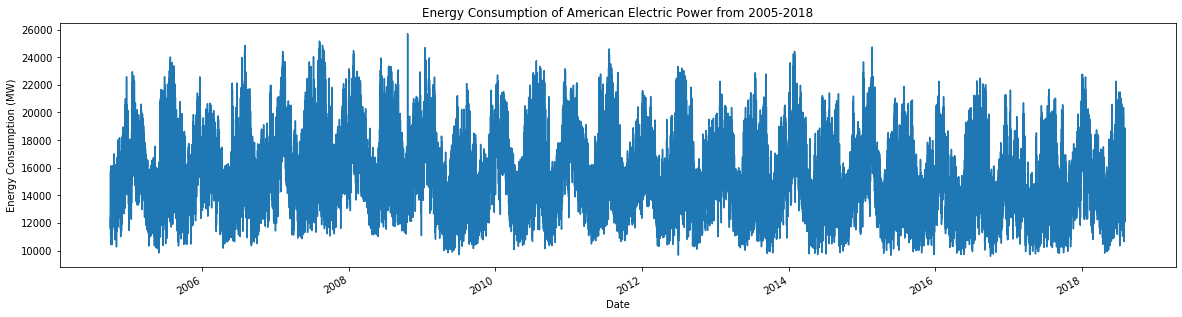

In [ ]:
def show_graph(dataset, date):
  df.plot(figsize=(20,5))
  plt.xlabel("Date")
  plt.ylabel("Energy Consumption (MW)")
  plt.title("Energy Consumption of American Electric Power " + date)
  plt.show()

show_graph(df, date ="from 2005-2018")

In [ ]:
print(df.size)
print(df.shape)
print(df.isna().sum())

121273
(121273,)
0


### Preparing Data

In [ ]:
df = pd.read_csv('AEP_hourly.csv')
df = np.array(df[2207:10967])
print(df)
print("\n\n\n")

# drop time
df = df[:, 1]
print(df)
print(df.shape)

[['2005-12-31 01:00:00' 14254.0]
 ['2005-12-31 02:00:00' 13761.0]
 ['2005-12-31 03:00:00' 13445.0]
 ...
 ['2005-01-02 00:00:00' 12849.0]
 ['2006-12-31 01:00:00' 13055.0]
 ['2006-12-31 02:00:00' 12610.0]]




[14254.0 13761.0 13445.0 ... 12849.0 13055.0 12610.0]
(8760,)


In [ ]:
def sequential_window_dataset(series, window_size):
    # series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[-1]))
    return ds.batch(1).prefetch(1)

In [ ]:
def load_data(stock, seq_len):

    split_time = 7200

    #1 first 7200 days are going to be used in training
    x_train = df[:split_time]
    x_train = np.array(x_train)
    x_train = np.reshape(x_train, (7200, seq_len, 1))

    #2 last 1560 days are going to be used in test
    x_valid = df[split_time:]
    x_valid = np.array(x_valid)
    x_valid = np.reshape(x_valid, (x_valid.shape[0], seq_len, 1))


load_data(df, 1)

In [ ]:
print(x_train)
x_train = df[:7200]
def my_func(arg):
  arg = tf.convert_to_tensor(arg, dtype=tf.float32)
  return arg
my_func(x_train)
print(x_train)

[14254.0 13761.0 13445.0 ... 14717.0 14275.0 13884.0]
[14254.0 13761.0 13445.0 ... 14717.0 14275.0 13884.0]


In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

### Coding LSTM

In [ ]:
print(len(x_train))
print(x_train[0])
print(x_train.shape)

x_train = np.asarray(x_train).astype(np.float32)
x_valid = np.asarray(x_valid).astype(np.float32)

x_train = tf.data.Dataset.from_tensor_slices(x_train)
hi = x_train.window(window_size + 1, shift=window_size, drop_remainder=True)
hi = hi.flat_map(lambda window: window.batch(window_size + 1))
hi = hi.map(lambda window: (window[:-1], window[-1]))
print(hi)

7200
14254.0
(7200,)
<MapDataset shapes: ((None,), ()), types: (tf.float32, tf.float32)>


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 7
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True, 
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])



ValueError: ignored